In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from parse_data import get_data, get_modified_values, get_binary_values, make_data_scalar
import random
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)



def make_data(df, device, seq_len):

    x_train, y_train = [], []
    prev = []
    m = df.max()[0]
    #print(df)
    for row in df.values:
        
        if len(prev) < seq_len:
            before = [0]*(seq_len - len(prev))
            for a in prev:
                before.append(a)
            #print(before)
            x_train.append(before)
        else:   
            x_train.append(prev[-seq_len:])
        y_train.append(row[0]/m)
        prev.append(row[0]/m)
    return x_train,y_train


def feature_engineering(X,Y):
    new_x, new_y = [], []
    count = 100
    for x, y in zip(X,Y):
        for i in range(count):
            curr_x = []
            for x_part in x:
                if random.random() > (i /(count+1)):
                    to_add = x_part + np.random.normal(loc=0, scale=0.01)
                else:
                    to_add = x_part
                if to_add > 1:
                    to_add = 1
                if to_add < 0:
                    to_add = 0
                curr_x.append(to_add)
            new_x.append(curr_x)
            new_y.append(y)
        #new_x.append(x)
        #new_y.append(y)
    return new_x, new_y

def eval_model(y,yhat, name="forcing"):
   
    fig, ax = plt.subplots(2)
    
    ax[0].plot(range(1,51), yhat[:50])
    ax[0].plot( range(1,51), y[:50])

    ax[1].plot(range(2000,2050), yhat[2000:2050])
    
    ax[1].plot(range(2000,2050), y[2000:2050] )
    fig.suptitle("Fitting to data with XGBoost")
    fig.savefig("images/teacher_forcing%s.png" % name)

X, y = make_data(get_data(), None, 100)

X, y = feature_engineering(X,y)

print(X[0])

Using device:  cuda
[0, 0, 0, 0.002592205759613769, 0.019219462336730282, 0, 0.0072210214336118185, 0.00595437341700162, 0, 0.007590345817806764, 0.005125014227210413, 0, 0, 0, 0.023155371255220707, 0, 0.014031628415666709, 0, 0, 0.018937111647293413, 0, 0, 0.01469034403561508, 0, 0, 0, 0.006844835911487708, 0, 0.023190733364035508, 0, 0, 0, 0.015473560847246673, 0.011540344550203797, 0, 0.007724802504031586, 0.011506255543849929, 0.003148498905301435, 0, 0, 0, 0, 0.005801751290077409, 0, 0, 0.002528955679907382, 0, 0.003599672297047442, 0.008676108882657243, 0, 0, 0, 0, 0, 0.0005141396146364688, 0, 0.0013737770003728264, 0.002458544330640028, 0, 0.005501979001284253, 0, 0.0034058259078641, 0.012197784741353928, 0.00023201921939624708, 0, 0, 0.006942146660344056, 0, 0.011606763496524857, 0, 0.010817408334786314, 0, 0.013509506358469038, 0, 0, 0, 0.004940380174248003, 0, 0, 0.003057158233883367, 0.005872837128364589, 0.00017389184150587366, 0.010464656040572593, 0, 0.007520713548328209,

In [2]:


model = xgb.XGBRegressor()
model.fit(X, y)
# make a single prediction
row = X[200:]
#print(row)
yhat = model.predict(X)
print('Prediction: %f' % yhat[65], "Actual: ", y[65])

correct = 0
count = 0
for y_val, yh in zip(y, yhat):
    count += 1 
    if yhat[0] == yh:
        correct += 1
print(correct, count)
    

Prediction: 0.991124 Actual:  1.0
1 815200


New best model.
	New loss: 0.3651584595943398 
	Old loss: 10000000000000000000000
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.001, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 50, 'max_leaves': 0, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 50, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': 'gradient_based', 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
New best model.


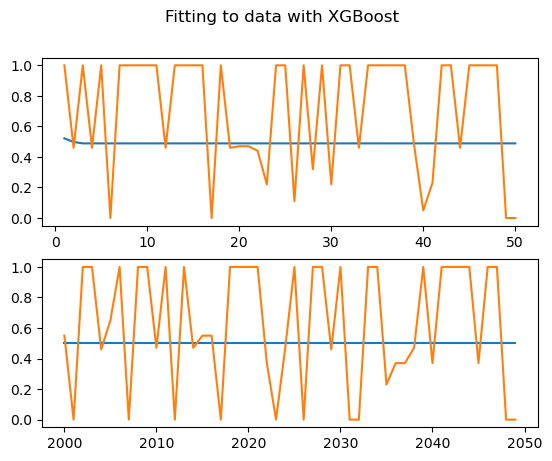

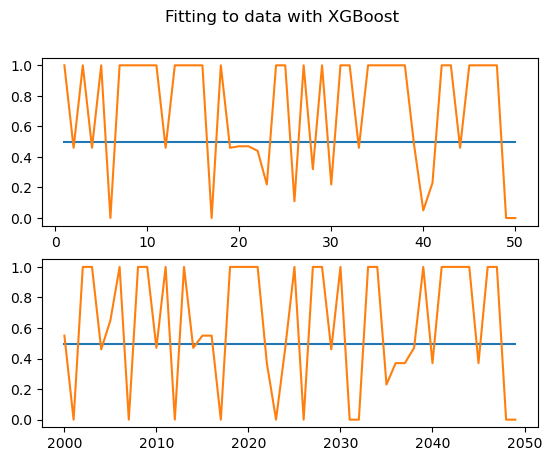

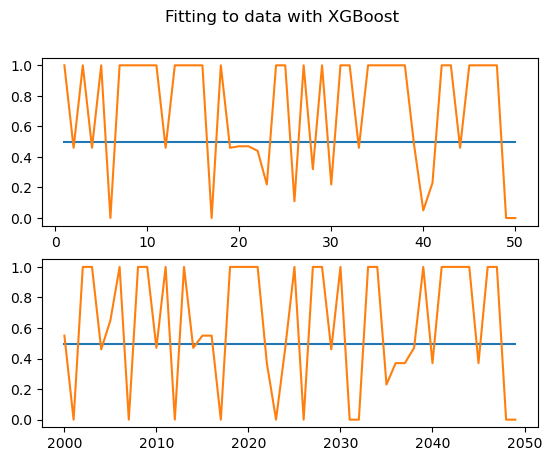

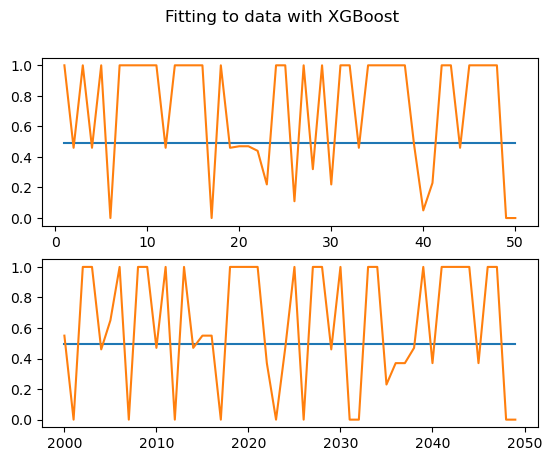

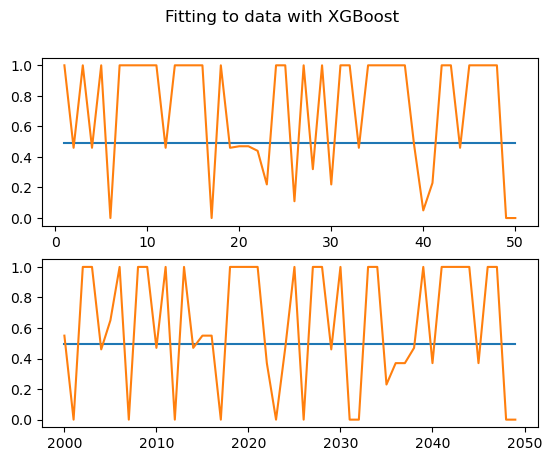

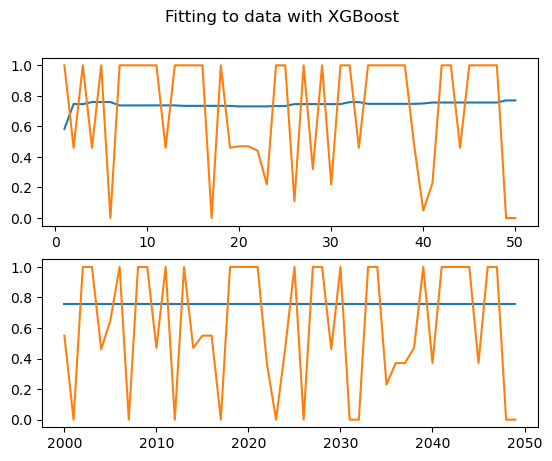

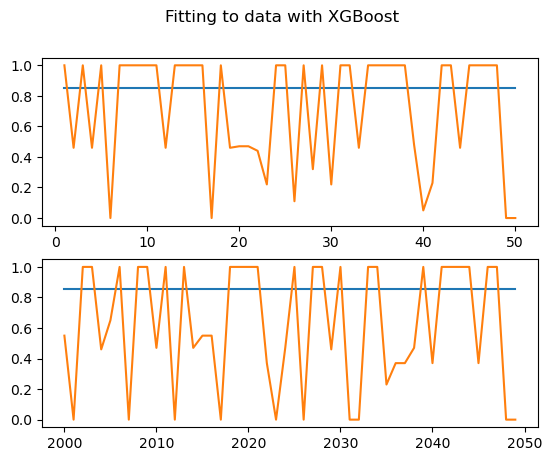

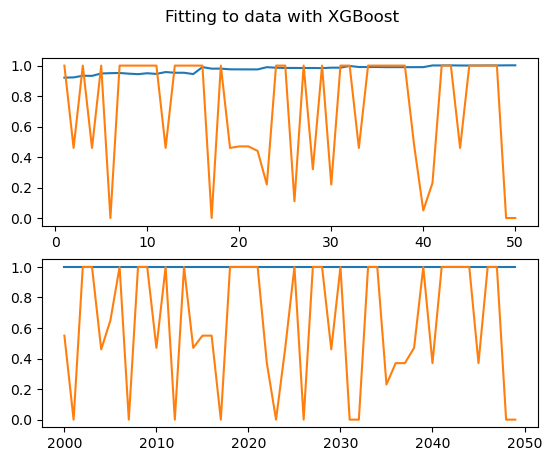

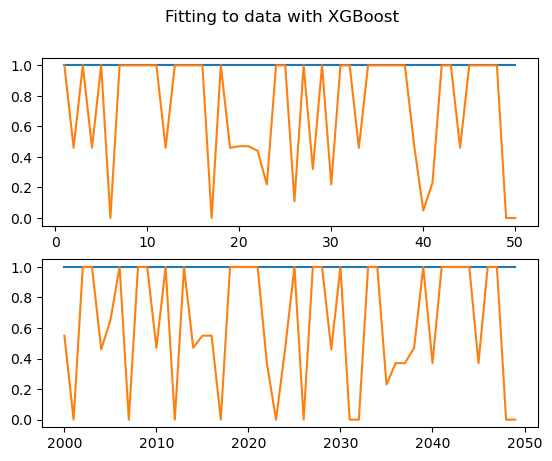

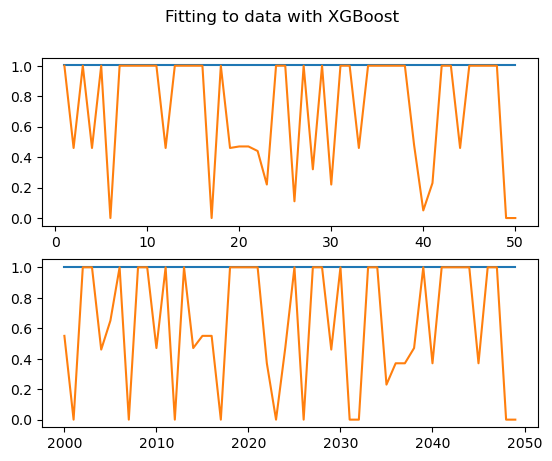

In [3]:
def try_model(x,y, lr, estimators, max_depth, x_eval, y_eval, loss="squared_error"):
    model = xgb.XGBRegressor(learning_rate=lr, n_estimators=estimators, max_depth=max_depth, max_leaves=0, sampling_method="gradient_based")
    
    model.fit(x,y )
    
    return model

def model_score(model,x,y):
    yhat = model.predict(x)
    return mean_absolute_error(y,yhat)

def model_generate(model, x):
    
    res = []
    prev = x[0]
    for _ in x:
        v = model.predict([prev])[0]
        res.append(v)
        prev.pop(0)
        prev.append(v)
        
    return res
        
        

learning_rate = [0.001, 0.01, 0.1, 0.005, 0.05]
max_depth = [ 50, 100,1,2,5,10,25,200]
estimators = [50, 100, 200, 500]*3

x_eval, y_eval = X, y = make_data(get_data(), None, 100)
X_corr, y_corr = make_data(get_data(), None, 100)

best_m = None
best_loss = 10000000000000000000000
for lr in learning_rate:
    for depth in max_depth:
        for est in estimators:
            m = try_model(X,y, lr, est, depth,  x_eval, y_eval, loss="absolute_error",)
            loss = model_score(m,x_eval,y_eval)
            if loss < best_loss:
                print("New best model.\n\tNew loss:", loss, "\n\tOld loss:", best_loss)
                best_loss = loss
                best_m = m
                print(m.get_params())
                
                yhat = model_generate(m, X_corr)
                eval_model(y_corr,yhat, name="%s%s%s" % (str(lr), str(depth), str(est)))



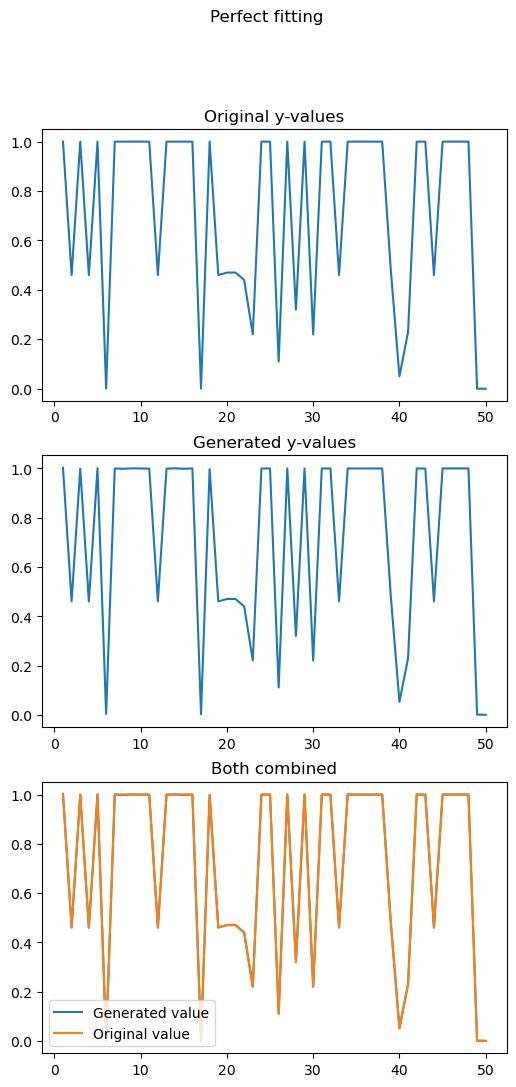

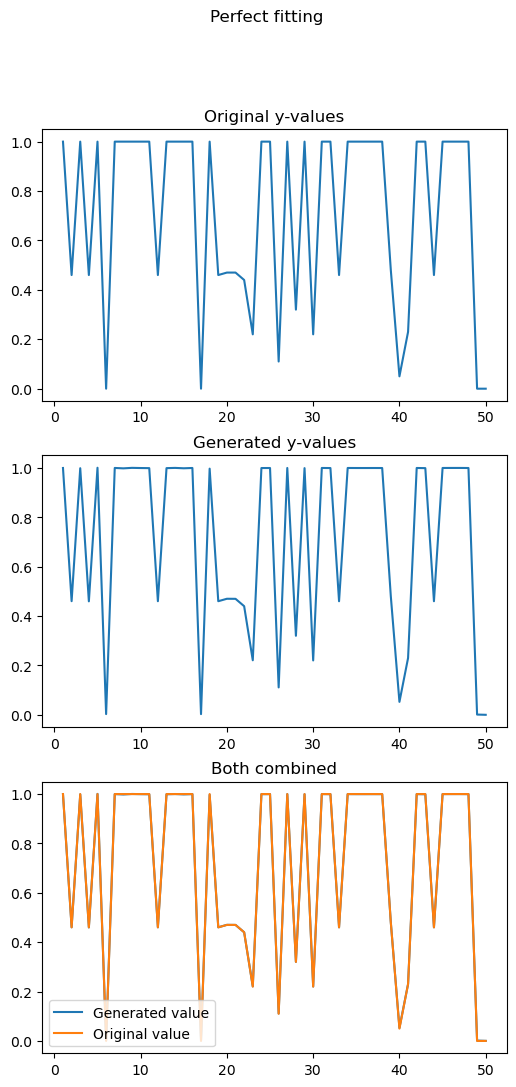

In [15]:


def no_teacher_forcing(model, X, amount):
    curr_x = [0]*(len(X[0]))
    new_y = []
    
    for i in range(amount):
        y = model.predict([curr_x])
        curr_x.pop(0)
        curr_x.append(y[0])
        new_y.append(y)
    return new_y

def eval_model(y,yhat, name="forcing"):
   
    fig, ax = plt.subplots(3, figsize=(6,12))
    
    #ax[0].plot(range(1,51), yhat[:50], label="Generated value")
    ax[0].plot( range(1,51), y[:50], label="Original value")
    ax[0].set_title("Original y-values")
    ax[1].plot(range(1,51), yhat[:50])
    ax[1].set_title("Generated y-values")
    
    ax[2].plot(range(1,51), yhat[:50], label="Generated value")
    ax[2].plot( range(1,51), y[:50], label="Original value")
    ax[2].set_title("Both combined")
    ax[2].legend()
    #ax[1].plot(range(10,20), y[10:20] )
    fig.suptitle("Perfect fitting")
    fig.savefig("teacher_forcing%s.png" % name)

    

yhat = best_m.predict(X_corr)


eval_model(y_corr,yhat)

yhat = no_teacher_forcing(best_m, X_corr, len(y_corr))

eval_model(y_corr, yhat, name="non-forcing")